# Progetto di Big data in geographical information system
## Analisi e forecasting delle serie temporali

Federico Luzzi - 816753

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import xarray as xr

import datetime as dtm
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf, pacf
import pmdarima as pm # auto_arima models
from dateutil.relativedelta import relativedelta # for months difference
from statsmodels.tsa.seasonal import seasonal_decompose # seasonal decomposition
from sklearn.linear_model import LinearRegression # linear regression

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Caricamento dataset

In [3]:
# crut
crut = pd.read_csv('models/crut4_7457_ts.csv')
crut['time'] = pd.to_datetime(crut['time'], format="%Y-%m-%d")
crut = crut.set_index(['time'])

# ipsl
ipsl = pd.read_csv('models/ipsl_ts.csv')
ipsl['time'] = pd.to_datetime(ipsl['time'], format="%Y-%m-%d")
ipsl = ipsl.set_index(['time'])

In [4]:
crut.head()

,value
time,
1850-01-31,-3.407028
1850-02-28,0.436040
1850-03-31,-1.410218
1850-04-30,-1.300772
1850-05-31,-1.002276


In [5]:
ipsl.head()

,value
time,
1850-01-31,-0.882162
1850-02-28,-0.768894
1850-03-31,-0.796424
1850-04-30,-0.784580
1850-05-31,-0.680309


Seleziono il periodo 1901-2014, ovvero il periodo di dati comune tra le due serie storiche più consistente

In [6]:
crut = crut[(crut.index.year >= 1900)]
crut = crut[(crut.index.year <= 2014)]
crut.shape

(1380, 1)

In [7]:
ipsl = ipsl[(ipsl.index.year >= 1900)]
ipsl = ipsl[(ipsl.index.year <= 2014)]
ipsl.shape

(1380, 1)

## Plot versione annuale

In [8]:
crut_y = crut.groupby(crut.index.year).mean()
ipsl_y = ipsl.groupby(ipsl.index.year).mean()

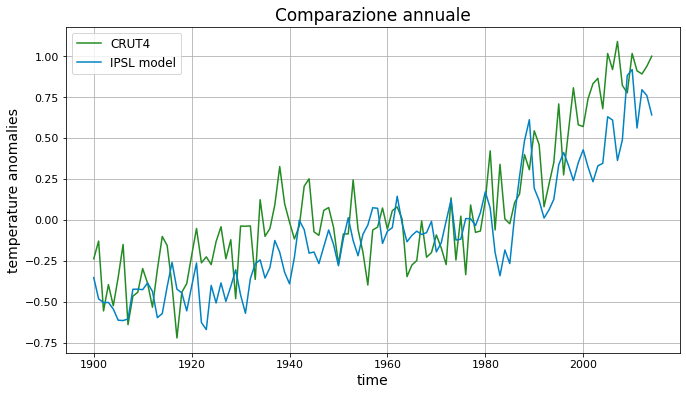

In [9]:
plt.figure(figsize = (11,6))
plt.plot(crut_y.index, crut_y.value, color = "forestgreen", label = "CRUT4")
plt.plot(ipsl_y.value, color = "#0082C3", label = "IPSL model")

plt.title("Comparazione annuale", size = 17)
plt.legend(fontsize = 12)
plt.xlabel("time", size = 14)
plt.ylabel("temperature anomalies", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)

plt.grid()

Si può notare anche graficamente che le due serie di anomalie hanno comportamento simile. Verifichiamo l'indipendenza tra le due medie tramite un ``t-test``

In [10]:
t, p_value_t = stats.ttest_ind(crut_y.value, ipsl_y.value, equal_var = False)
print(f"T-test = {round(t,4)}, p-value = {round(p_value_t,4)}")

T-test = 2.7693, p-value = 0.0061


Con un p value decisamente significativo rifiutiamo l'ipotesi nulla di indipendenza tra le due serie.

Valutiamo ora tramite il coefficiente di ``pearson`` il grado di correlazione.

In [11]:
s, p_value_s = stats.pearsonr(crut_y.value, ipsl_y.value)
print(f"Pearson = {round(s,4)}, p-value = {round(p_value_s,4)}")

Pearson = 0.8337, p-value = 0.0


Con un p-value < 0.05 abbiamo che le due serie storiche sono correlate con un coefficiente di pearson consistente che indica proporzionalità diretta, al crescere di una cresce anche l'altra.

## Comparazione serie storiche mensili
Per una comparazione più approfondita si visualizzano le serie storiche mese per mese

In [12]:
crut_m = []
for i in range(12):
    crut_m.append(crut[crut.index.month == i+1])

In [13]:
ipsl_m = []
for i in range(12):
    ipsl_m.append(ipsl[ipsl.index.month == i+1])

In [14]:
mese = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 
        'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

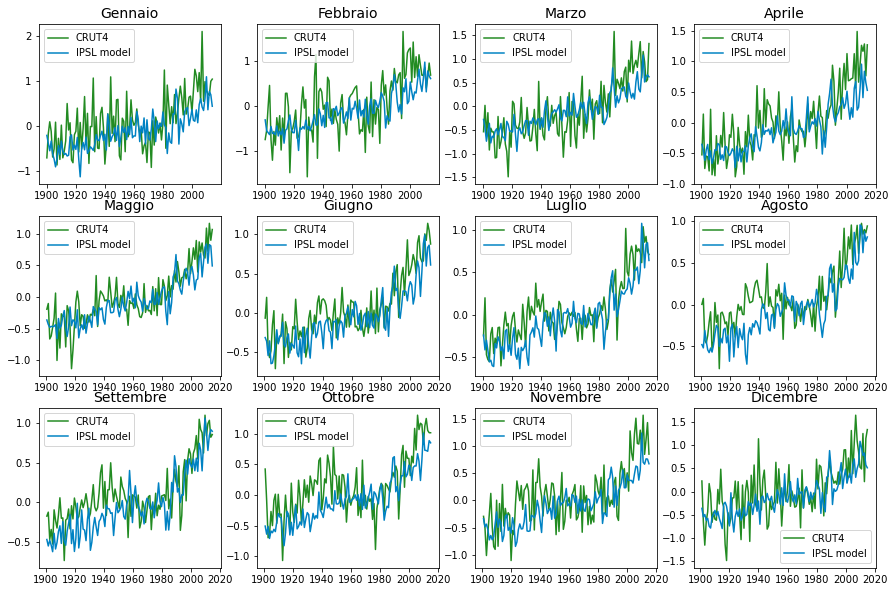

In [15]:
plt.subplots(nrows=3, ncols=4, figsize=(15,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.plot(crut_m[i].index, crut_m[i].value, color = "forestgreen", label = "CRUT4")
    plt.plot(ipsl_m[i].value, color = "#0082C3", label = "IPSL model")
    plt.title(mese[i], fontsize = 14)
    plt.legend(fontsize = 10)

Si può notare graficamente che l'andamento delle due serie storiche sono associabili. Ovviamente Crut4 ha andamenti più ballerini in quanto si basa su dati reali.

### T-test di indipendenza

In [16]:
for i in range(12):
    t, p_value = stats.ttest_ind(crut_m[i].value, ipsl_m[i].value, equal_var = False)
    print(f"{mese[i]}, t = {round(t,4)}, p-value = {round(p_value,4)}")

Gennaio, t = 3.4776, p-value = 0.0006
Febbraio, t = 2.2238, p-value = 0.0274
Marzo, t = 0.4995, p-value = 0.618
Aprile, t = 2.4396, p-value = 0.0156
Maggio, t = 1.4456, p-value = 0.1497
Giugno, t = 2.6355, p-value = 0.009
Luglio, t = 2.5256, p-value = 0.0122
Agosto, t = 3.2545, p-value = 0.0013
Settembre, t = 2.8185, p-value = 0.0053
Ottobre, t = 3.827, p-value = 0.0002
Novembre, t = 2.6918, p-value = 0.0077
Dicembre, t = 1.9615, p-value = 0.0512


In [17]:
for i in range(12):
    s, p_value = stats.pearsonr(crut_m[i].value, ipsl_m[i].value)
    print(f"{mese[i]}, pearson = {round(s,4)}, p-value = {round(p_value,4)}")

Gennaio, pearson = 0.4658, p-value = 0.0
Febbraio, pearson = 0.6148, p-value = 0.0
Marzo, pearson = 0.6974, p-value = 0.0
Aprile, pearson = 0.7492, p-value = 0.0
Maggio, pearson = 0.8053, p-value = 0.0
Giugno, pearson = 0.7972, p-value = 0.0
Luglio, pearson = 0.7766, p-value = 0.0
Agosto, pearson = 0.7563, p-value = 0.0
Settembre, pearson = 0.7713, p-value = 0.0
Ottobre, pearson = 0.6749, p-value = 0.0
Novembre, pearson = 0.6371, p-value = 0.0
Dicembre, pearson = 0.5387, p-value = 0.0


Da questi test si nota che gennaio è un mese un po' anomalo rispetto gli altri, le cui medie sono viste come dipendenti e ha un valore di pearson più basso rispetto gli altri mesi. In ogni caso risultano correlati dal test.

---

# Trend Analysis

## Crut

Scomposizione nelle componenti principali (metodo additivo)

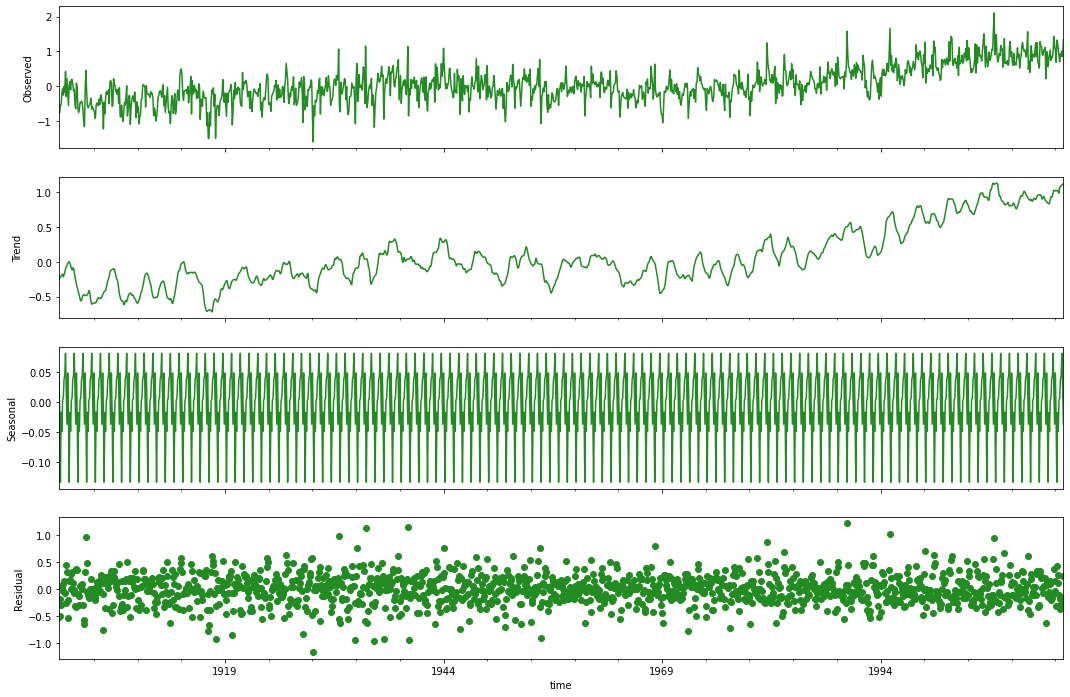

In [18]:
result_add = seasonal_decompose(crut.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False, color = "forestgreen")
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False, color = "forestgreen")
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False, color = "forestgreen")
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o', color = "forestgreen")
axes[3].set_ylabel('Residual')
plt.show()

Estrazione del trend

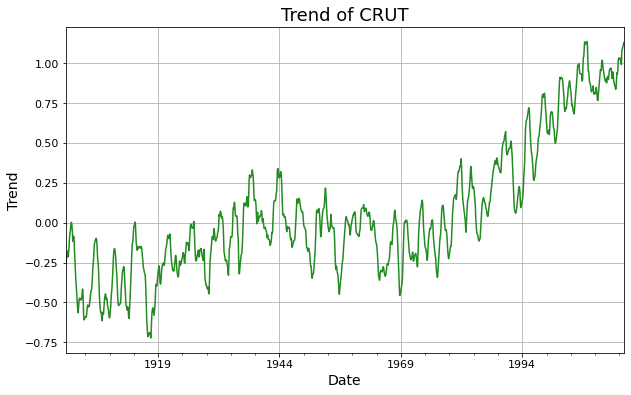

In [19]:
result_add = seasonal_decompose(crut.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of CRUT', size = 18)
trend.plot(ax=axes, legend=False, color = "forestgreen")
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.grid()
plt.show()

Effettuo una semplice regressione lineare

In [20]:
trend_val = trend.values
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
time_line = sm.add_constant(time_line)
model = sm.OLS(trend_val, time_line).fit()

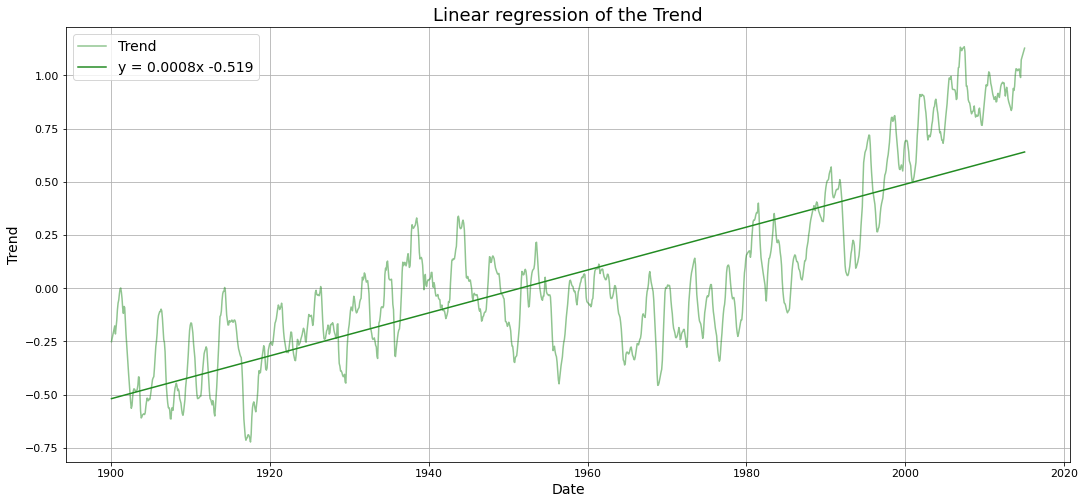

In [21]:
line_regr = model.predict(time_line)

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend.values, color = "forestgreen", alpha = 0.5, label = "Trend")
plt.plot(trend.index, line_regr, color = "forestgreen",
         label = f"y = {round(model.params[1],4)}x {round(model.params[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

In [22]:
print(f"r2 score è {round(model.rsquared,4)}")
print(f"Adjusted r2 score  è {round(model.rsquared_adj,4)}")

r2 score è 0.6538
Adjusted r2 score  è 0.6535


Anche una semplice regressione lineare mostra un trend chiaramente crescente. Per modellare meglio il trend si è deciso di applicare delle regressioni polionomiali in modo da apprezzare le modifiche dell'andamento nel tempo.

### Regressione polinomiale

In [23]:
# calcola la regressione di grado i dati in input x e y
def regression_polynomial(x, y, i):
    # tutte i gradi di x della regressione
    data = pd.DataFrame({'x':x, 'y':y})
    variables = ['x']
    for j in range(2, i+1):
        variables.append(f'x{j}')
        data[f'x{j}'] = data['x'] ** j
    
    X = data[variables]
    Y = data['y']

    X = sm.add_constant(X) # aggiungo la costante
    model = sm.OLS(Y, X).fit()
    
    return model

Regressioni polinomiale di 2, 3 e 4 grado

In [24]:
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])

model_2 = regression_polynomial(time_line, trend, 2)
model_3 = regression_polynomial(time_line, trend, 3)
model_4 = regression_polynomial(time_line, trend, 4)

In [25]:
# plot risultante dall'applicazione della regressione polinomiale
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')
def plot_regression(model, time_line, value, i):
    x = np.linspace(time_line.min(), time_line.max(), len(time_line))
    label = f"y = {round(model.params['const'],3)} + {round(model.params['x'],3)}*x "
    yhat = model.params['const'] + model.params['x'] * x
    for j in range(2, i+1):
        label = label + f"+ {round(model.params[f'x{j}'],3)}*x^{j} "
        yhat += model.params[f'x{j}'] * (x**j)
    
    plt.plot(time_ax, yhat, lw=2, c='forestgreen', label = label)
    plt.plot(time_ax, value, color="forestgreen", alpha=.5)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.xlabel("Data", size=12)
    plt.ylabel("Trend", size=12)

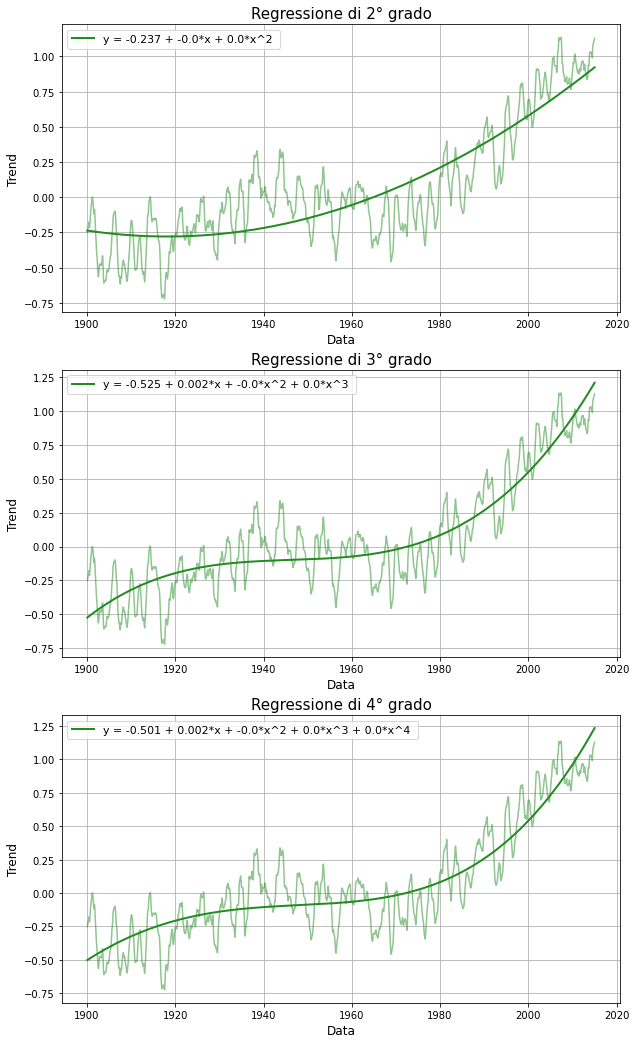

In [26]:
plt.subplots(3,1, figsize = (10,18))
for z,model in enumerate([model_2,model_3,model_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model, time_line, trend, z+2)
    plt.title(f"Regressione di {z+2}° grado", size=15)

In [27]:
print(f"r2 of model base: {round(model.rsquared,4)}, r2 adjusted: {round(model.rsquared_adj,4)}")
print(f"r2 of model 2° grado: {round(model_2.rsquared,4)}, r2 adjusted: {round(model_2.rsquared_adj,4)}")
print(f"r2 of model 3° grado: {round(model_3.rsquared,4)}, r2 adjusted: {round(model_3.rsquared_adj,4)}")
print(f"r2 of model 4° grado: {round(model_4.rsquared,4)}, r2 adjusted: {round(model_4.rsquared_adj,4)}")

r2 of model base: 0.8171, r2 adjusted: 0.8165
r2 of model 2° grado: 0.7471, r2 adjusted: 0.7467
r2 of model 3° grado: 0.8167, r2 adjusted: 0.8163
r2 of model 4° grado: 0.8171, r2 adjusted: 0.8165


Si può notare che ora l'andamento della regressione fitta molto meglio il trend, anche l'indice $r^2$ ci mostra un miglioramento nello nella modellazione.

Forse il modello che meglio si adatta è quello con 3 gradi di regressione, in cui ho una parte iniziale in leggera crescita, una stazionarietà sullo 0 coincidente con il periodo di riferimento, ed infine una crescita decisa successiva agli anni 90.

## IPSL

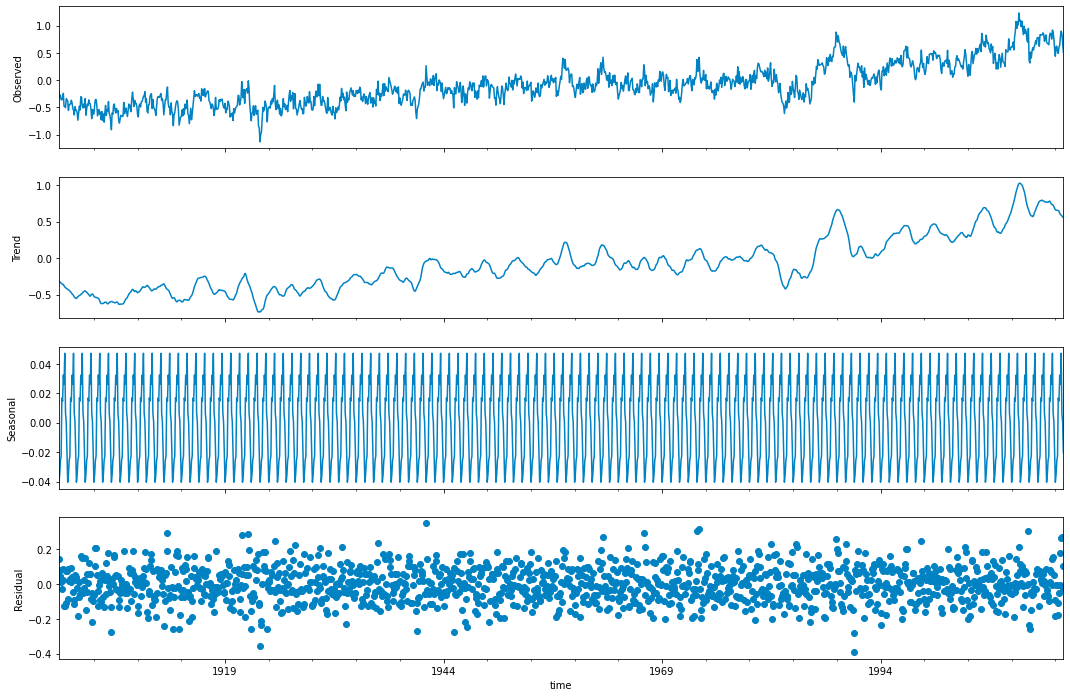

In [28]:
result_add = seasonal_decompose(ipsl.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False, color = '#0082C3')
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False, color = '#0082C3')
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False, color = '#0082C3')
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o', color = '#0082C3')
axes[3].set_ylabel('Residual')
plt.show()

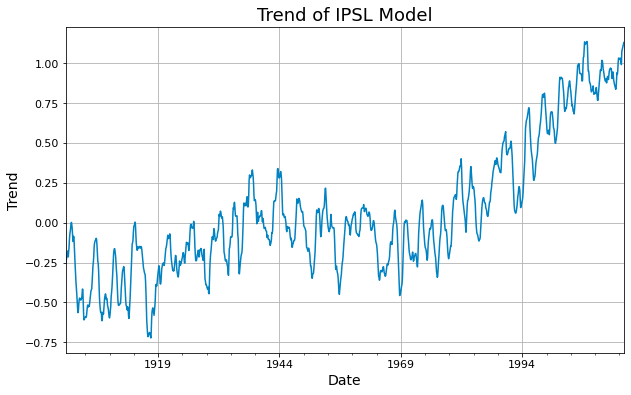

In [29]:
result_add = seasonal_decompose(ipsl.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend_ipsl = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of IPSL Model', size = 18)
trend.plot(ax=axes, legend=False, color = '#0082C3')
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.grid()
plt.show()

Si può notare un trend più smooth rispetto a quello di crut4

Effettuo una semplice regressione lineare

In [30]:
trend_ipsl_val = trend_ipsl.values
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
time_line = sm.add_constant(time_line)
model_ipsl = sm.OLS(trend_ipsl_val, time_line).fit()

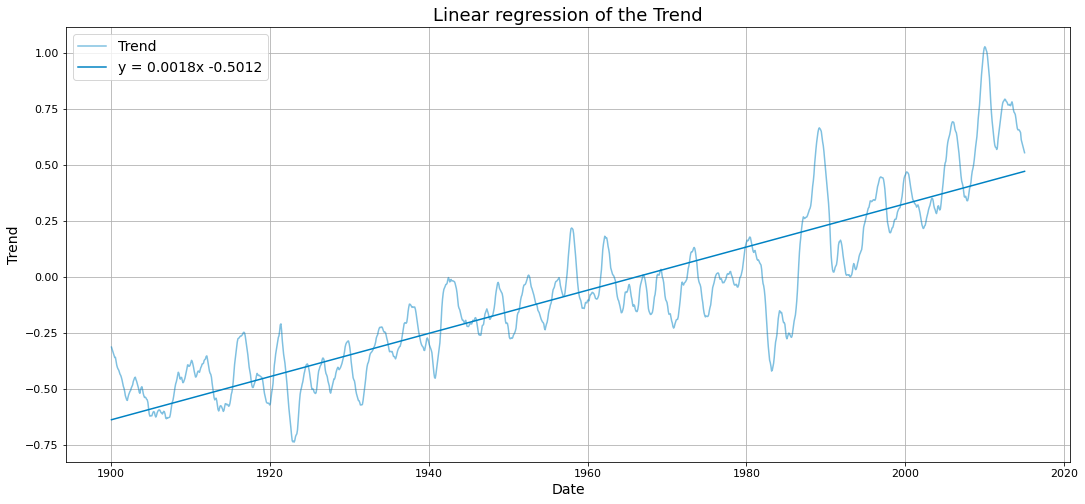

In [31]:
line_regr = model_ipsl.predict(time_line)

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend_ipsl.values, color = '#0082C3', alpha=.5, label = "Trend")
plt.plot(trend.index, line_regr, color = "#0082C3", 
         label = f"y = {round(model.params[1],4)}x {round(model.params[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

In [32]:
print(f"r2 score è {round(model_ipsl.rsquared,4)}")
print(f"Adjusted r2 score  è {round(model_ipsl.rsquared_adj,4)}")

r2 score è 0.7877
Adjusted r2 score  è 0.7875


Già la regressione lineare sembra essere molto efficace, però per un'analisi più approfondità, la regressione polinomiale si preferisce.

### Regressione polinomiale

In [33]:
# plot risultante dall'applicazione della regressione polinomiale
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')
def plot_regression(model, time_line, value, i):
    x = np.linspace(time_line.min(), time_line.max(), len(time_line))
    label = f"y = {round(model.params['const'],3)} + {round(model.params['x'],3)}*x "
    yhat = model.params['const'] + model.params['x'] * x
    for j in range(2, i+1):
        label = label + f"+ {round(model.params[f'x{j}'],3)}*x^{j} "
        yhat += model.params[f'x{j}'] * (x**j)
    
    plt.plot(time_ax, yhat, lw=2, c='#0082C3', label = label)
    plt.plot(time_ax, value, color="#0082C3", alpha=.5)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.xlabel("Data", size=12)
    plt.ylabel("Trend", size=12)

In [34]:
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
model_ipsl_2 = regression_polynomial(time_line, trend_ipsl, 2)
model_ipsl_3 = regression_polynomial(time_line, trend_ipsl, 3)
model_ipsl_4 = regression_polynomial(time_line, trend_ipsl, 4)

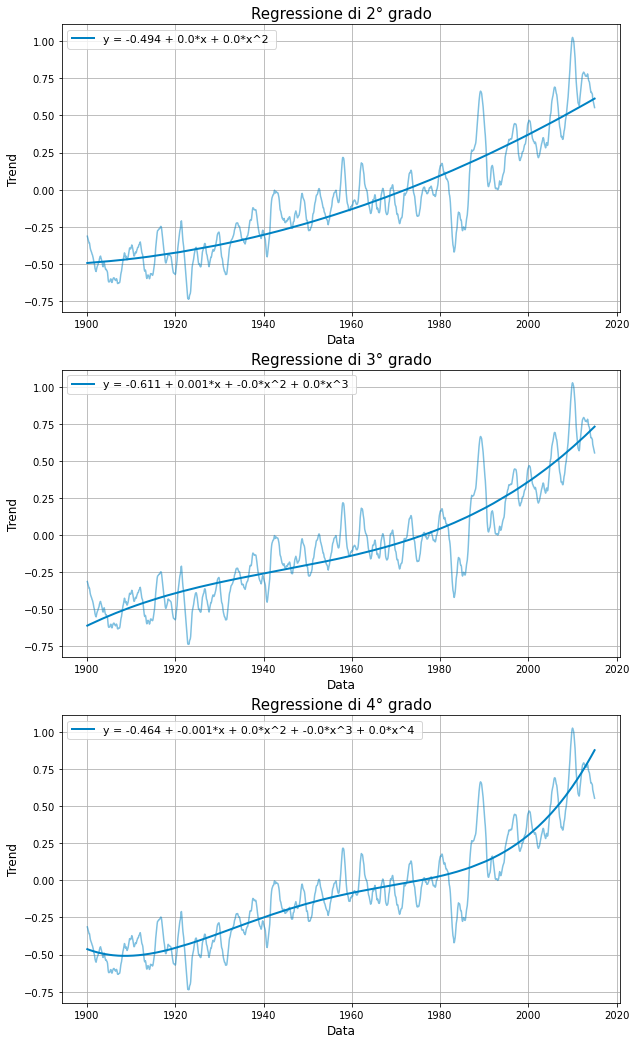

In [35]:
plt.subplots(3,1, figsize = (10,18))
for z,model in enumerate([model_ipsl_2,model_ipsl_3,model_ipsl_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model, time_line, trend_ipsl, z+2)
    plt.title(f"Regressione di {z+2}° grado", size=15)

In [36]:
print(f"r2 of model base: {round(model.rsquared,4)}, r2 adjusted: {round(model.rsquared_adj,4)}")
print(f"r2 of model 2° grado: {round(model_ipsl_2.rsquared,4)}, r2 adjusted: {round(model_ipsl_2.rsquared_adj,4)}")
print(f"r2 of model 3° grado: {round(model_ipsl_3.rsquared,4)}, r2 adjusted: {round(model_ipsl_3.rsquared_adj,4)}")
print(f"r2 of model 4° grado: {round(model_ipsl_4.rsquared,4)}, r2 adjusted: {round(model_ipsl_4.rsquared_adj,4)}")

r2 of model base: 0.8532, r2 adjusted: 0.8528
r2 of model 2° grado: 0.8195, r2 adjusted: 0.8192
r2 of model 3° grado: 0.8345, r2 adjusted: 0.8341
r2 of model 4° grado: 0.8532, r2 adjusted: 0.8528


## Trend regression comparison

Text(0, 0.5, 'Trend')

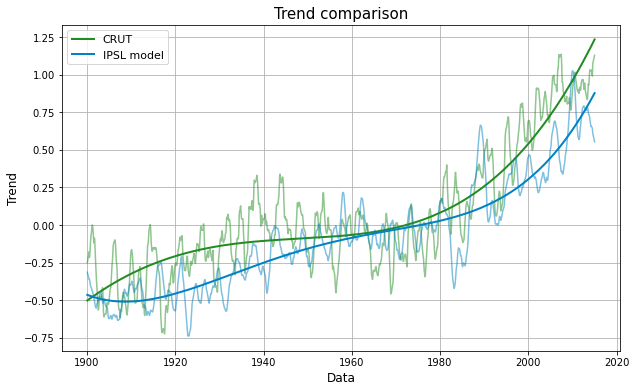

In [37]:
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

# crut trend
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
x = np.linspace(time_line.min(), time_line.max(), len(time_line))

yhat = model_4.params['const'] + model_4.params['x'] * x
for j in range(2, 5):
    yhat += model_4.params[f'x{j}'] * (x**j)

    
# ipsl trend
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
x = np.linspace(time_line.min(), time_line.max(), len(time_line))

yhat_ipsl = model_ipsl_4.params['const'] + model_ipsl_4.params['x'] * x
for j in range(2, 5):
    yhat_ipsl += model_ipsl_4.params[f'x{j}'] * (x**j)

plt.subplots(figsize=(10,6))
# crut trned
plt.plot(time_ax, yhat, lw=2, c='forestgreen', label = 'CRUT')
plt.plot(time_ax, trend, color='forestgreen', alpha=0.5)
# ipsl trend
plt.plot(time_ax, yhat_ipsl, lw=2, c='#0082C3', label = 'IPSL model')
plt.plot(time_ax, trend_ipsl, color='#0082C3', alpha=0.5)

plt.title("Trend comparison", size=15)
plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel("Data", size=12)
plt.ylabel("Trend", size=12)

In [38]:
t, p_value_t = stats.ttest_ind(trend, trend_ipsl, equal_var = False)
print(f"T-test = {round(t,4)}, p-value = {round(p_value_t,4)}")
s, p_value_s = stats.pearsonr(trend, trend_ipsl)
print(f"Pearson = {round(s,4)}, p-value = {round(p_value_s,4)}")

T-test = 9.76, p-value = 0.0
Pearson = 0.8329, p-value = 0.0


---

---

# Arima modeling

## Crut

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

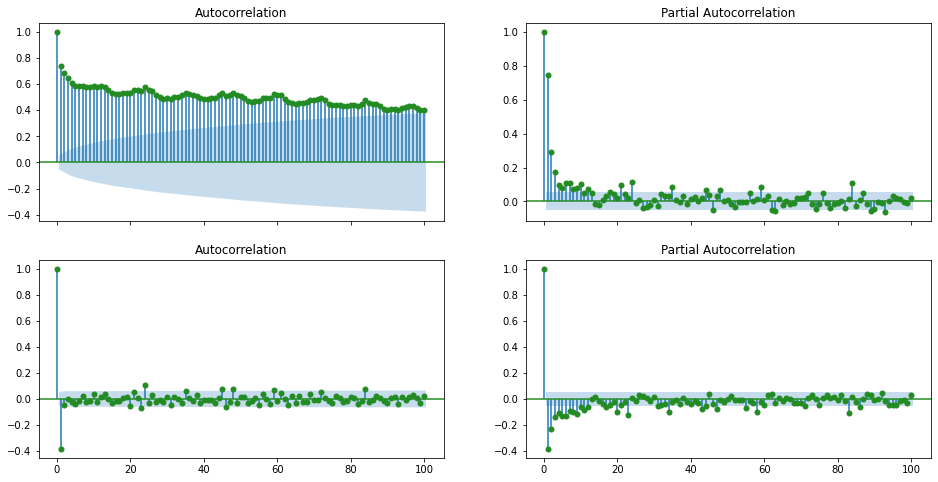

In [39]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(crut, lags=100, ax=axes[0][0], color = 'forestgreen')
plot_acf(crut.diff().dropna(), lags=100, ax=axes[1][0], color = 'forestgreen')
plot_pacf(crut, lags=100, ax=axes[0][1], color = 'forestgreen')
plot_pacf(crut.diff().dropna(), lags=100, ax=axes[1][1], color = 'forestgreen')
plt.show()

**Split** training set e test set. Test set ultimi 3 anni (2012-2014).

In [40]:
crut_train = crut.iloc[:-36] 
crut_test = crut.iloc[-36:]

In [41]:
smodel = pm.auto_arima(crut_train, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1968.284, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1294.208, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1747.053, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1179.218, Time=0.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1397.914, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1091.726, Time=0.83 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1206.234, Time=0.44 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1059.358, Time=1.02 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1171.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1344
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -523.679
Date:                            Fri, 18 Jun 2021   AIC                           1059.358
Time:                                    18:35:30   BIC                           1090.520
Sample:                                         0   HQIC                          1071.036
                                           - 1344                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5327      0.021    -25.937      0.000      -0.573      -0.492
ar.L2         -0.3341      0.027    -12.327      0.000      -0.387      -0.281
ar.L3         -0.1603      0.028     -5.796      0.000      -0.214      -0.106
ar.S.L12      -0.6974      0.020    -35.141      0.000      -0.736      -0.659
ar.S.L24      -0.2897      0.021    -13.860      0.000      -0.331      -0.249
sigma2         0.1280      0.004     33.400      0.000       0.120       0.135
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):               148.16
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

In [42]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

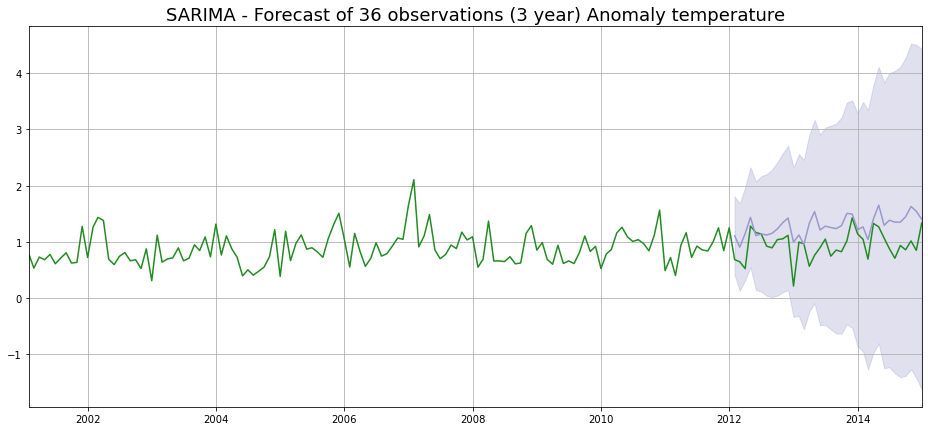

In [43]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(crut.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(crut.index, crut.value, color = 'forestgreen')

plt.plot(future, fitted_series, color='#9999CC')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='#9999CC', alpha=.3)
plt.xlim(crut_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [44]:
mse = mean_squared_error(fitted_series, crut_test)
mae = mean_absolute_error(fitted_series, crut_test)
s, p_value = stats.pearsonr(np.array(fitted_series), crut_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.1735
MAE: 0.3482
Pearson: 0.4445, p-value: 0.0066


Graficamente si nota una lieve sovrastima generale della serie storica. Il CI, come ci si aspetta, si amplia man mano che si procede con il forecasting.

Vedendo i risultati delle performance abbiamo un mse decisamente basso ma un mae un può più elevanto, però pari a solo 0.34 gradi di anomalia. Direi molto soddisfaciente come modello.

Inoltre il coefficiente di pearson ci definisce un legame importante tra la serie predetta e quella reale.

### 12 Arima mensili

**Split** training e test set

In [45]:
crut_m_train = []
crut_m_test = []
for month in range(12):
    crut_m_train.append(crut_m[month][:-3]) 
    crut_m_test.append(crut_m[month][-3:])

In [46]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(crut_m_train[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=153.565, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=234.027, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=184.961, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=155.782, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=232.066, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=155.538, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=155.508, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=153.743, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=174.824, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=157.489, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=154.307, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.563 seconds
 ------------------------ 
Computing ARIMA month 1
 ------------------------ 
Performin

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=103.181, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=153.912, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=105.152, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=104.852, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=104.305, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.251 seconds
 ------------------------ 
Computing ARIMA month 11
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=148.106, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=188.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=165.863, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=175.288, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=149.942, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=149.955, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=168.661, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[

#### Prediction

In [47]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

n_periods = 3
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(crut_m_train[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='12M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

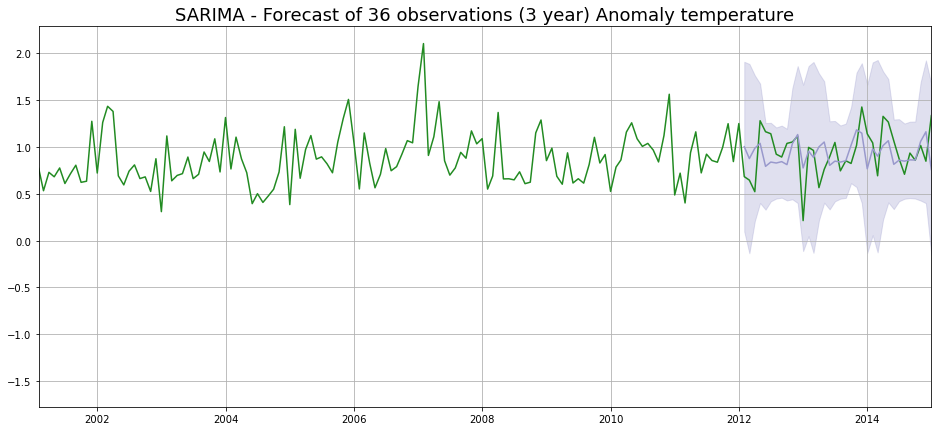

In [48]:
plt.figure(figsize=(16, 7))

plt.plot(crut.index, crut.value, color = 'forestgreen')

plt.plot(fitted_series.index, fitted_series.values, color='#9999CC')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='#9999CC', alpha=.3)
plt.xlim(crut_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [49]:
mse = mean_squared_error(fitted_series, crut_test)
mae = mean_absolute_error(fitted_series, crut_test)
s, p_value = stats.pearsonr(fitted_series[0].values, crut_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0657
MAE: 0.2039
Pearson: 0.1814, p-value: 0.2898


Tramite questa soluzione abbiamo un forecast molto più performante, con un CI ristretto ma comunque contiene tutti i valori reali della serie storica. 

Le performance sono decisamente migliorate, anche se il coefficiente di pearson non segnala correlazione tra la serie predetta con quella reale. 

## Model IPSL

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

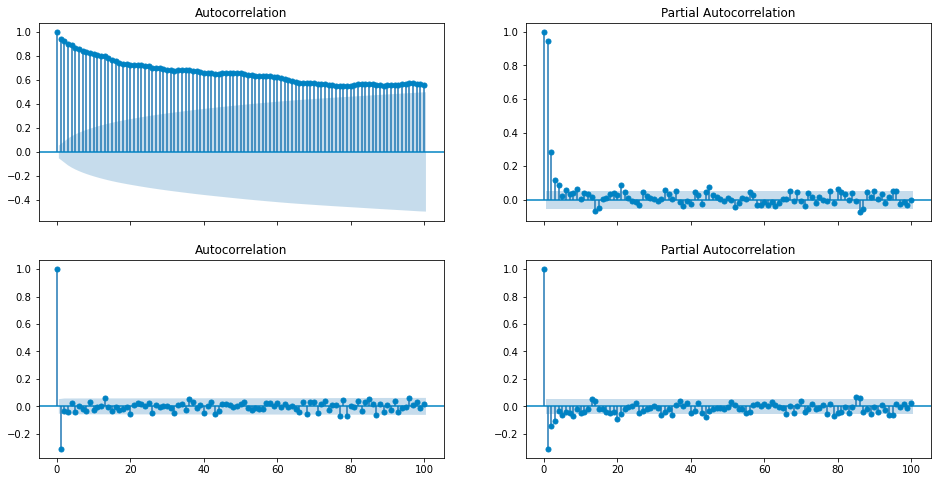

In [50]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(ipsl, lags=100, ax=axes[0][0], color = '#0082C3')
plot_acf(ipsl.diff().dropna(), lags=100, ax=axes[1][0], color = '#0082C3')
plot_pacf(ipsl, lags=100, ax=axes[0][1], color = '#0082C3')
plot_pacf(ipsl.diff().dropna(), lags=100, ax=axes[1][1], color = '#0082C3')
plt.show()

Split training and test set

In [51]:
ipsl_train = ipsl.iloc[:-36] 
ipsl_test = ipsl.iloc[-36:]

In [52]:
smodel = pm.auto_arima(ipsl_train, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-810.280, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1348.335, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-979.068, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1535.514, Time=0.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1375.321, Time=0.50 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1565.244, Time=0.97 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-1374.502, Time=0.50 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1582.652, Time=1.17 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1344
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 797.326
Date:                            Fri, 18 Jun 2021   AIC                          -1582.652
Time:                                    18:36:09   BIC                          -1551.490
Sample:                                         0   HQIC                         -1570.974
                                           - 1344                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4091      0.027    -14.902      0.000      -0.463      -0.355
ar.L2         -0.2005      0.028     -7.096      0.000      -0.256      -0.145
ar.L3         -0.1205      0.027     -4.455      0.000      -0.173      -0.067
ar.S.L12      -0.6814      0.025    -27.153      0.000      -0.731      -0.632
ar.S.L24      -0.3720      0.025    -14.730      0.000      -0.421      -0.322
sigma2         0.0176      0.001     26.354      0.000       0.016       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.97   Prob(JB):                         0.75
Heteroskedasticity (H):               1.00   Skew:                             0.02
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

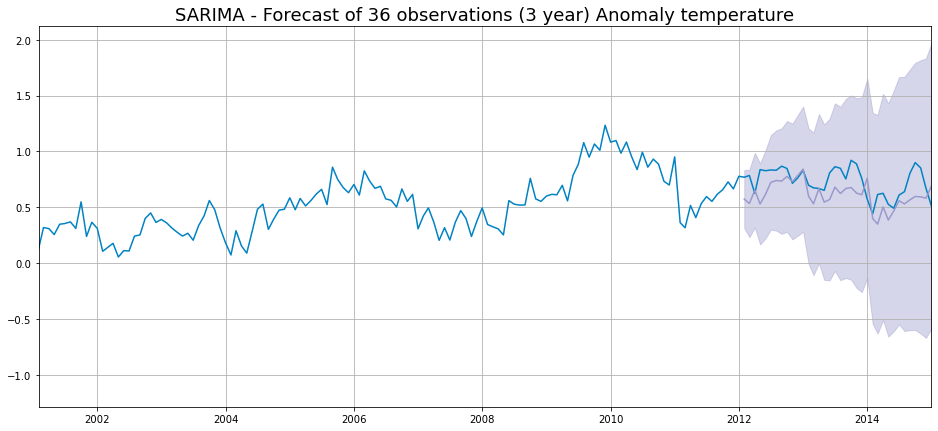

In [53]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ipsl.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(ipsl.index, ipsl.value, color = '#0082C3')

plt.plot(future, fitted_series, color='#9999CC')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='#9999CC', alpha=.4)
plt.xlim(ipsl_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [54]:
mse = mean_squared_error(fitted_series, ipsl_test)
mae = mean_absolute_error(fitted_series, ipsl_test)
s, p_value = stats.pearsonr(np.array(fitted_series), ipsl_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0288
MAE: 0.1441
Pearson: 0.4939, p-value: 0.0022


Graficamente possiamo notare come la previsione sia sottostimata rispetto al valore reale del test, in alcuni frangenti è persino fuori dall'intervallo di confidenza. 

Le performance tuttavia sono buone, con un coefficiente di pearson che non segnala correlazione significativa.

### Arima mensili

Split training e test set

In [55]:
ipsl_m_train = []
ipsl_m_test = []
for month in range(12):
    ipsl_m_train.append(ipsl_m[month][:-3]) 
    ipsl_m_test.append(ipsl_m[month][-3:])

In [56]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(ipsl_m_train[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24.158, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=120.120, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.680, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=79.524, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24.865, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24.767, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=65.850, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.575, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=22.197, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=24.098, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=24.107, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=26.721, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=26.677, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf,

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-64.671, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-71.318, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-66.726, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-69.318, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-69.318, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-67.993, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-67.325, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-66.610, Time=0.10 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.328 seconds
 ------------------------ 
Computing ARIMA month 9
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-65.678, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.187, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.831, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0

#### Prediction

In [57]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

n_periods = 3
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(ipsl_m_train[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='12M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

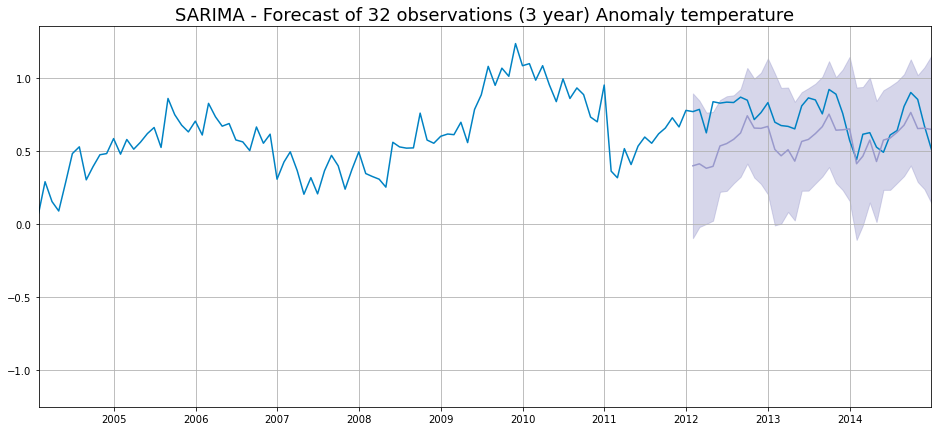

In [58]:
plt.figure(figsize=(16, 7))

plt.plot(ipsl.index, ipsl.value, color = '#0082C3')

plt.plot(fitted_series.index, fitted_series.values, color='#9999CC')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='#9999CC', alpha=.4)
plt.xlim(ipsl.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 32 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [59]:
mse = mean_squared_error(fitted_series, ipsl_test)
mae = mean_absolute_error(fitted_series, ipsl_test)
s, p_value = stats.pearsonr(fitted_series[0].values, ipsl_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0408
MAE: 0.1727
Pearson: 0.4021, p-value: 0.0151


Graficamente si nota un netto miglioramento rispetto al modello precedente, la serie è sempre sottostimata però rimane sempre all'interno dell'intervallo di confidenza e comprende correttamente l'andamento generale.

Anche le misure di performance sono decisamente migliori. Il coefficiente di Pearson segnala una correlazione leggera ma significativa.

Anche per quanto riguarda il model IPSL si nota una modellazione efficace tramite questa tecnica con sensibile miglioramento dell'indice $r^2$.